
Condiciones actuales:
Clima en Bogotá, CO: No disponible
Duración normal del viaje: 10 hours 25 mins
Duración con tráfico actual: 10 hours 56 mins
Distancia total: 709 km

Recomendación de la IA:
¡Hola! Gracias por proporcionar los datos necesarios para planificar tu ruta. Considerando tu preferencia por rutas seguras y el tráfico actual, te recomiendo la siguiente ruta:

**Ruta Recomendada:**

*   Desde tu ubicación actual, toma la autopista principal hacia tu destino.
*   Después de aproximadamente 200 km, encontrarás un desvío debido a trabajos en la carretera. No te preocupes, el desvío está bien señaló y no debería causarte retrasos significativos.
*   Continúa por la autopista durante otros 300 km hasta que llegues a una zona con posibles retrasos debido a un accidente. Te recomiendo tomar un desvío alternativo que te llevará por una ruta secundaria. Esto puede agregar unos 30 minutos a tu viaje, pero te evitará posibles retrasos más largos.
*   Después de pasar la zona del acci

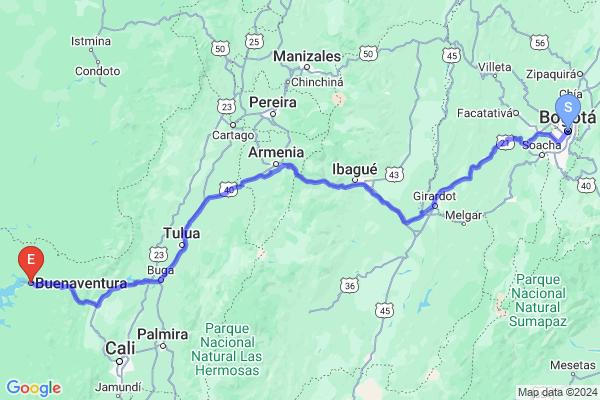

In [ ]:
import googlemaps
from openai import OpenAI
import requests
from IPython.display import Image, display
from datetime import datetime

# Configuración de las APIs
client_llama = OpenAI(
    base_url="https://integrate.api.nvidia.com/v1",
    api_key=""
)

gmaps = googlemaps.Client(key='')

# Función para obtener rutas desde Google Maps API
def obtener_ruta_google(origen, destino, preferencias):
    resultado = gmaps.directions(
        origin=origen,
        destination=destino,
        mode="driving",
        alternatives=True,
        avoid=preferencias  # Ej. ["highways", "tolls"] para evitar peajes y autopistas
    )
    return resultado

# Función para interactuar con Llama 3.1
def obtener_recomendacion_ruta_llama(trafico, distancia, clima, preferencias_usuario):
    mensaje_inicial = [
        {
            "role": "system",
            "content": (
                "Eres un asistente de rutas que ayuda a los usuarios a elegir la mejor ruta. "
                "Proporciona sugerencias muy detalladas, incluyendo posibles eventos en la vía como "
                "trabajos en la carretera, accidentes, condiciones del camino y paradas recomendadas. "
                "Considera el tráfico actual, el clima y las preferencias del usuario."
            )
        },
        {
            "role": "user",
            "content": (
                f"Datos del usuario:\n"
                f"- Tráfico: {trafico}\n"
                f"- Distancia: {distancia} km\n"
                f"- Clima: {clima}\n"
                f"- Preferencias: {preferencias_usuario}."
            )
        }
    ]
    
    completion = client_llama.chat.completions.create(
        model="meta/llama-3.1-405b-instruct",
        messages=mensaje_inicial,
        temperature=0.2,
        top_p=0.7,
        max_tokens=1024,
        stream=False
    )
    
    respuesta = completion.choices[0].message.content
    return respuesta

# Función para obtener la ruta desde Google Maps Directions API
def obtener_ruta_directions_api(origen, destino, api_key, waypoints=None):
    base_url = "https://maps.googleapis.com/maps/api/directions/json?"

    # Parámetros de la URL
    params = {
        "origin": origen,
        "destination": destino,
        "mode": "driving",
        "key": api_key
    }

    # Si hay waypoints (paradas intermedias), las añadimos
    if waypoints:
        params["waypoints"] = "|".join(waypoints)

    # Generar la URL con los parámetros
    url = base_url + "&".join([f"{key}={value}" for key, value in params.items()])

    response = requests.get(url)
    if response.status_code == 200:
        directions = response.json()
        if directions['status'] == 'OK':
            # Obtener el overview polyline
            ruta = directions['routes'][0]['overview_polyline']['points']
            return ruta
        else:
            print("Error en la respuesta de Directions API:", directions['status'])
            return None
    else:
        print("Error al obtener la ruta de Directions API.")
        return None

# Función para generar la URL de la imagen estática de Google Maps con la ruta real
def obtener_mapa_estatico(origen, destino, encoded_polyline, api_key):
    base_url = "https://maps.googleapis.com/maps/api/staticmap?"

    # Parámetros de la URL
    params = {
        "size": "600x400",  # Tamaño de la imagen
        "maptype": "roadmap",
        "markers": f"color:blue|label:S|{origen}&markers=color:red|label:E|{destino}",  # Marcadores
        "path": f"enc:{encoded_polyline}",  # Ruta usando la polilínea codificada
        "key": api_key
    }

    # Generar la URL con los parámetros
    url = base_url + "&".join([f"{key}={value}" for key, value in params.items()])
    return url

# Función para mostrar el mapa estático
def mostrar_mapa_estatico(url_mapa):
    response = requests.get(url_mapa)
    if response.status_code == 200:
        with open("mapa_estatico.png", "wb") as f:
            f.write(response.content)
        display(Image("mapa_estatico.png"))
    else:
        print("Error al obtener la imagen del mapa.")

def obtener_datos_clima(lat, lng, api_key_weather):
    """Obtiene datos climáticos de OpenWeatherMap API"""
    base_url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        "lat": lat,
        "lon": lng,
        "appid": api_key_weather,
        "units": "metric",
        "lang": "es"
    }
    
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        return f"{data['weather'][0]['description']}, {data['main']['temp']}°C"
    return "No disponible"

def obtener_datos_trafico(origen, destino, gmaps):
    """Obtiene datos de tráfico en tiempo real usando Google Maps Distance Matrix API"""
    now = datetime.now()
    matrix = gmaps.distance_matrix(
        origins=origen,
        destinations=destino,
        mode="driving",
        departure_time=now,
        traffic_model="best_guess"
    )
    
    if matrix['rows'][0]['elements'][0]['status'] == 'OK':
        duracion_normal = matrix['rows'][0]['elements'][0]['duration']['text']
        duracion_trafico = matrix['rows'][0]['elements'][0]['duration_in_traffic']['text']
        return duracion_normal, duracion_trafico
    return "No disponible", "No disponible"

# Modificación del ejemplo de uso
if __name__ == "__main__":
    origen = "Bogotá, CO"
    destino = "Buenaventura, CO"
    api_key_maps = ""
    api_key_weather = ""

    # Obtener coordenadas del origen para el clima
    geocode_origen = gmaps.geocode(origen)[0]['geometry']['location']
    lat = geocode_origen['lat']
    lng = geocode_origen['lng']

    # Obtener datos climáticos
    clima = obtener_datos_clima(lat, lng, api_key_weather)

    # Obtener datos de tráfico
    duracion_normal, duracion_trafico = obtener_datos_trafico(origen, destino, gmaps)

    # Obtener datos de la ruta
    rutas = obtener_ruta_google(origen, destino, ["tolls"])
    if rutas:
        ruta_principal = rutas[0]
        distancia = ruta_principal['legs'][0]['distance']['text']
        
        print(f"\nCondiciones actuales:")
        print(f"Clima en {origen}: {clima}")
        print(f"Duración normal del viaje: {duracion_normal}")
        print(f"Duración con tráfico actual: {duracion_trafico}")
        print(f"Distancia total: {distancia}")

        preferencias_usuario = "Preferencia por rutas seguras"

        # Obtener recomendación de la IA
        recomendacion = obtener_recomendacion_ruta_llama(
            trafico=duracion_trafico,
            distancia=distancia,
            clima=clima,
            preferencias_usuario=preferencias_usuario
        )
        print("\nRecomendación de la IA:")
        print(recomendacion)

        # Obtener y mostrar el mapa
        encoded_polyline = obtener_ruta_directions_api(origen, destino, api_key_maps)
        if encoded_polyline:
            url_mapa = obtener_mapa_estatico(origen, destino, encoded_polyline, api_key_maps)
            print("\nMostrando mapa de la ruta:")
            mostrar_mapa_estatico(url_mapa)


Condiciones actuales:
Clima en Bogotá, CO: No disponible
Duración normal del viaje: 10 hours 25 mins
Duración con tráfico actual: 10 hours 56 mins
Distancia total: 709 km

Recomendación de la IA:
¡Hola! Gracias por proporcionar los datos necesarios para planificar tu ruta. Considerando tu preferencia por rutas seguras y el tráfico actual, te recomiendo la siguiente ruta:

**Ruta Recomendada:**

*   Desde tu ubicación actual, toma la autopista principal hacia tu destino.
*   Después de aproximadamente 200 km, encontrarás un desvío debido a trabajos en la carretera. No te preocupes, el desvío está bien señaló y no debería causarte retrasos significativos.
*   Continúa por la autopista durante otros 300 km hasta que llegues a una zona con posibles retrasos debido a un accidente. Te recomiendo tomar un desvío alternativo que te llevará por una ruta secundaria. Esto puede agregar unos 30 minutos a tu viaje, pero te evitará posibles retrasos más largos.
*   Después de pasar la zona del accidente, vuelve a la autopista principal y continúa hacia tu destino.
*   Aproximadamente a 100 km de tu destino, encontrarás una zona con condiciones climáticas adversas. Te recomiendo reducir la velocidad y mantener una distancia segura con los vehículos que te preceden.
*   Finalmente, llega a tu destino después de un viaje de aproximadamente 11 horas y 30 minutos.

**Paradas Recomendadas:**

*   Después de 400 km, te recomiendo hacer una parada en un área de descanso para estirar las piernas y descansar un poco. Hay un restaurante y un baño en el área, por lo que podrás refrescarte y reponer energías.
*   Aproximadamente a 200 km de tu destino, te recomiendo hacer otra parada en un pueblo cercano para rellenar combustible y comprar algunos snacks.

**Condiciones del Camino:**

*   La autopista principal está en buen estado, pero es posible que encuentres algunos baches y desniveles en la ruta secundaria que tomas para evitar el accidente.
*   La zona con condiciones climáticas adversas puede ser resbalosa, por lo que es importante reducir la velocidad y mantener una distancia segura con los vehículos que te preceden.

**Eventos en la Vía:**

*   Trabajos en la carretera después de 200 km.
*   Accidente después de 500 km (toma el desvío alternativo).
*   Condiciones climáticas adversas a 100 km de tu destino.

Espero que esta información te sea útil para planificar tu viaje. ¡Disfruta tu viaje y llega seguro a tu destino!

Mostrando mapa de la ruta: